## Data Merging

### Import modules

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from scipy.stats import pearsonr

%matplotlib inline

### Import data

Let's import the training data and weather data. We want to merge these two as these two datasets contain the relevant features for our model.

In [135]:
train = pd.read_csv('../data/clean_train_df.csv')
weather = pd.read_csv('../data/clean_weather_df_NP.csv')

Let's look at the columns of each dataframe as they are our feature set.

In [136]:
train.columns,  weather.columns

(Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
        'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
        'NumMosquitos', 'WnvPresent', 'Year', 'Month', 'Day'],
       dtype='object'),
 Index(['Date', 'Station', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb',
        'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'SnowFall',
        'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir',
        'AvgSpeed', 'FG', 'FG+', 'VCTS', 'SN', 'RA', 'TS', 'FU', 'DZ', 'GR',
        'TSRA', 'SQ', 'MIFG', 'BCFG', 'BR', 'VCFG', 'HZ'],
       dtype='object'))

#### Clean up

Let's just make all the column names lowercase.

In [137]:
train.columns = train.columns.map(lambda x: x.lower())
weather.columns = weather.columns.map(lambda x: x.lower())

Let's also make our date columns DateTime columns:

In [138]:
train['date'] = pd.to_datetime(train['date'])

In [139]:
weather['date'] = pd.to_datetime(weather['date'])

Let's also add some lagged temperature data to our weather data:

In [140]:
weather['tavg_7'] = weather[['tavg']].rolling(7).mean()
weather['tavg_30'] = weather[['tavg']].rolling(30).mean()

weather['tavg_7'].fillna(weather['tavg'], inplace=True)
weather['tavg_30'].fillna(weather['tavg'], inplace=True)

#### What about Spray?

We do not want the spray dataset in our merged data as it doesn't have very many relevant features. Let's take a look:

In [141]:
spray = pd.read_csv('../data/cleaned_spray.csv')

In [142]:
spray.columns

Index(['date', 'time', 'latitude', 'longitude'], dtype='object')

In [143]:
spray.date.unique()

array(['2011-08-29', '2011-09-07', '2013-07-17', '2013-07-25',
       '2013-08-08', '2013-08-15', '2013-08-16', '2013-08-22',
       '2013-08-29', '2013-09-05'], dtype=object)

We will not use the spray data as a feature in our merged data because there are only 10 different days in which spraying happened. Also, our test data does not contain any of the dates represented by the spraying data.

What we might use spraying data for is check how much mosquito counts decreases in the two week period after a spray, in order to perform a cost-benefit analysis.

### Merging the dataframes

We'd like to merge our dataframes on the date column (to align observations by date). Note that the weather dataframe has two observations per date - one for each station. We don't need both stations, as this will duplicate the number of observations in our training set, so let's drop one station.

In [144]:
weather.drop(weather[weather.station == 2].index, inplace=True)

Whereas the train dataframe has multiple observations per date - given the different traps.

In [145]:
train[train['date'] == '2007-05-29'][['date']].count()

date    25
dtype: int64

Let's now merge the dateframes together on the date column. This will cause some dates from the weather dataset to be dropped, as not all dates present in the weather dataframe are present in the train dataset. The vice versa is also true, but to a much lesser degree.

#### Merge!

In [146]:
train_weather = pd.merge(train, weather, on='date')

In [147]:
print(" Train shape:", train.shape, '\n',
      "Merged shape:", train_weather.shape)

 Train shape: (10506, 15) 
 Merged shape: (10413, 51)


In [148]:
train.columns

Index(['date', 'address', 'species', 'block', 'street', 'trap',
       'addressnumberandstreet', 'latitude', 'longitude', 'addressaccuracy',
       'nummosquitos', 'wnvpresent', 'year', 'month', 'day'],
      dtype='object')

In [149]:
weather.columns

Index(['date', 'station', 'tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb',
       'heat', 'cool', 'sunrise', 'sunset', 'codesum', 'snowfall',
       'preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir',
       'avgspeed', 'fg', 'fg+', 'vcts', 'sn', 'ra', 'ts', 'fu', 'dz', 'gr',
       'tsra', 'sq', 'mifg', 'bcfg', 'br', 'vcfg', 'hz', 'tavg_7', 'tavg_30'],
      dtype='object')

### Lagged Data

Let's see if any of our features have a high correlation with the presence of west nile virus when a lag is applied:

#### Temperature

In [150]:
wnv_by_date = train_weather.groupby(['date'])[['wnvpresent']].mean().reset_index()

In [151]:
wnv_by_date.set_index('date', inplace=True)

In [152]:
wnv_by_date = wnv_by_date.join(
    train_weather.groupby('date').mean()[['tavg', 'tavg_7', 'tavg_30']]
)

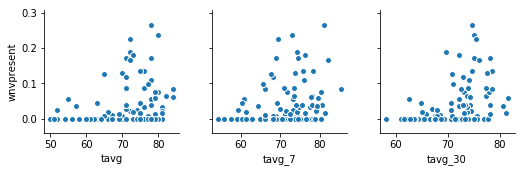

In [153]:
sns.pairplot(data = wnv_by_date,
                  y_vars=['wnvpresent'],
                  x_vars=['tavg', 'tavg_7', 'tavg_30'])

There seems to be a slight positive relationship. Let's take a look at the Pearson correlation.

In [154]:
print("Daily Temp and # WNV Corr:", pearsonr(wnv_by_date['wnvpresent'], mosqs_by_date['tavg']))
print("7-Day MA Temp and # WNV Corr:", pearsonr(wnv_by_date['wnvpresent'], mosqs_by_date['tavg_7']))
print("30-Day MA Temp and # WNV Corr:", pearsonr(wnv_by_date['wnvpresent'], mosqs_by_date['tavg_30']))

Daily Temp and # WNV Corr: (0.26910908089790814, 0.00872175780067811)
7-Day MA Temp and # WNV Corr: (0.2558903960226755, 0.012797721464047049)
30-Day MA Temp and # WNV Corr: (0.37579142290563466, 0.00018961693115660536)


There appears to be a moderate positive relationship between temperature for the day and the presence of west nile. There is a stronger relationship with the 30-day moving average temperate and the presence of west nile than with the daily average temperature.

### Precipitation

In [155]:
wnv_by_date = wnv_by_date.join(train_weather.groupby('date').mean()[['preciptotal']])

wnv_by_date['preciptotal_shift6'] = train_weather.groupby('date').mean()[['preciptotal']].shift(6)
wnv_by_date['preciptotal_shift6'].fillna(wnv_by_date['preciptotal'], inplace=True)

wnv_by_date['preciptotal_shift30'] = train_weather.groupby('date').mean()[['preciptotal']].shift(30)
wnv_by_date['preciptotal_shift30'].fillna(wnv_by_date['preciptotal'], inplace=True)

In [156]:
wnv_by_date.head(10)

,wnvpresent,tavg,tavg_7,tavg_30,preciptotal,preciptotal_shift6,preciptotal_shift30
date,,,,,,,
2007-05-29,0.000000,74.0,64.857143,64.800000,0.000,0.00,0.000
2007-06-05,0.000000,56.0,67.714286,69.933333,0.420,0.42,0.420
2007-06-26,0.000000,81.0,72.142857,74.633333,0.160,0.16,0.160
2007-06-29,0.000000,63.0,75.714286,74.766667,0.000,0.00,0.000
2007-07-02,0.000000,66.0,66.285714,72.900000,0.000,0.00,0.000
2007-07-11,0.000000,70.0,80.428571,75.333333,0.000,0.00,0.000
2007-07-18,0.007752,77.0,74.285714,75.600000,1.550,0.00,1.550
2007-07-19,0.000000,73.0,75.285714,75.600000,0.160,0.42,0.160
2007-07-25,0.054348,78.0,73.142857,72.200000,0.001,0.16,0.001


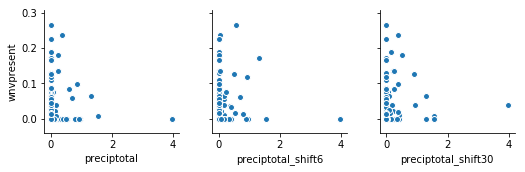

In [157]:
sns.pairplot(data = wnv_by_date,
                  y_vars=['wnvpresent'],
                  x_vars=['preciptotal', 'preciptotal_shift6', 'preciptotal_shift30'])

There seems to be a slight positive relationship. Let's take a look at the Pearson correlation.

In [158]:
print("Daily Temp and # Mosq Corr:", pearsonr(wnv_by_date['wnvpresent'], wnv_by_date['preciptotal']))
print("Daily Temp and # Mosq Corr:", pearsonr(wnv_by_date['wnvpresent'], wnv_by_date['preciptotal_shift6']))
print("Daily Temp and # Mosq Corr:", pearsonr(wnv_by_date['wnvpresent'], wnv_by_date['preciptotal_shift30']))

Daily Temp and # Mosq Corr: (-0.08941570081080007, 0.3914246921567155)
Daily Temp and # Mosq Corr: (-0.0013993105486766674, 0.9893203946835953)
Daily Temp and # Mosq Corr: (0.009299881164297218, 0.929112753112525)


There appears to be no relationship between precipitation totals or lagged precipitation totals and the number of mosquitos.

## Exporting merged data

In [159]:
# train_weather.to_csv('../data/train_weather_merged.csv', index=False)